# TSFresh exploration

In [110]:
from tsfresh import select_features, extract_relevant_features, extract_features
from tsfresh.utilities.dataframe_functions import impute
from get_processed_data import get_processed_data, get_train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [9]:
# train, test  = get_train_test_split(
#   'malte', 60 * 15, 60 * 3
# )

# print("train hard", len(train["hard"]))
# print("train easy", len(train["easy"]))

# print("test hard", len(test["hard"]))
# print("test easy", len(test["easy"]))


## Prepare data for TSFresh
Convert data to a single pandas dataframe and generate a unique id for each climb.

Also, generate a labels array, that indicates 0 for an easy route and 1 for a hard route for each climb.

In [15]:
easy_routes = get_processed_data("malte", ["3", "4", "5", ], 60 * 15, 60 * 3)
hard_routes = get_processed_data("malte", ["6", "6+", "7"], 60 * 15, 60 * 3)

all_climbs = []
labels = pd.Series() # 0 = not hard, 1 = hard
i = 0


for route in easy_routes:
    data  = pd.DataFrame(route)
    data = data.drop("PacketCounter", axis=1)
    data["id"] = i
    all_climbs.append(data)
    labels[i] = False
    i += 1

for route in hard_routes:
    data  = pd.DataFrame(route)
    data = data.drop("PacketCounter", axis=1)
    data["id"] = i
    all_climbs.append(data)
    labels[i] = True
    i += 1

all_climbs_df = pd.concat(all_climbs)

In [16]:
# now we can extract features from all_climbs
extracted_features = extract_features(all_climbs_df, column_id="id", column_sort="SampleTimeFine", column_kind=None, column_value=None)
extracted_features.to_csv("extracted_features.csv")

Feature Extraction: 100%|██████████| 20/20 [12:46<00:00, 38.33s/it]


In [6]:
# extracted_features = pd.read_csv("extracted_features.csv", index_col=0)


In [115]:
from tsfresh.feature_selection.relevance import calculate_relevance_table

# impute

impute(extracted_features)

relevance_table = calculate_relevance_table(extracted_features, labels)
relevance_table = relevance_table[relevance_table.relevant]
relevance_table.sort_values("p_value", inplace=True, ascending=True)

In [116]:
relevance_table[:15]



,feature,type,p_value,relevant
feature,,,,
FreeAcc_Z__quantile__q_0.2,FreeAcc_Z__quantile__q_0.2,real,2.197586e-14,True
FreeAcc_Z__range_count__max_1__min_-1,FreeAcc_Z__range_count__max_1__min_-1,real,6.981370e-14,True
FreeAcc_Z__quantile__q_0.3,FreeAcc_Z__quantile__q_0.3,real,7.445366e-14,True
FreeAcc_Z__quantile__q_0.9,FreeAcc_Z__quantile__q_0.9,real,9.958397e-14,True
FreeAcc_Z__quantile__q_0.4,FreeAcc_Z__quantile__q_0.4,real,1.386016e-13,True
FreeAcc_X__spkt_welch_density__coeff_2,FreeAcc_X__spkt_welch_density__coeff_2,real,5.103814e-13,True
"FreeAcc_Z__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2","FreeAcc_Z__change_quantiles__f_agg_""var""__isab...",real,1.048543e-12,True
FreeAcc_Y__spkt_welch_density__coeff_2,FreeAcc_Y__spkt_welch_density__coeff_2,real,1.181133e-12,True
FreeAcc_Z__quantile__q_0.1,FreeAcc_Z__quantile__q_0.1,real,1.753247e-12,True


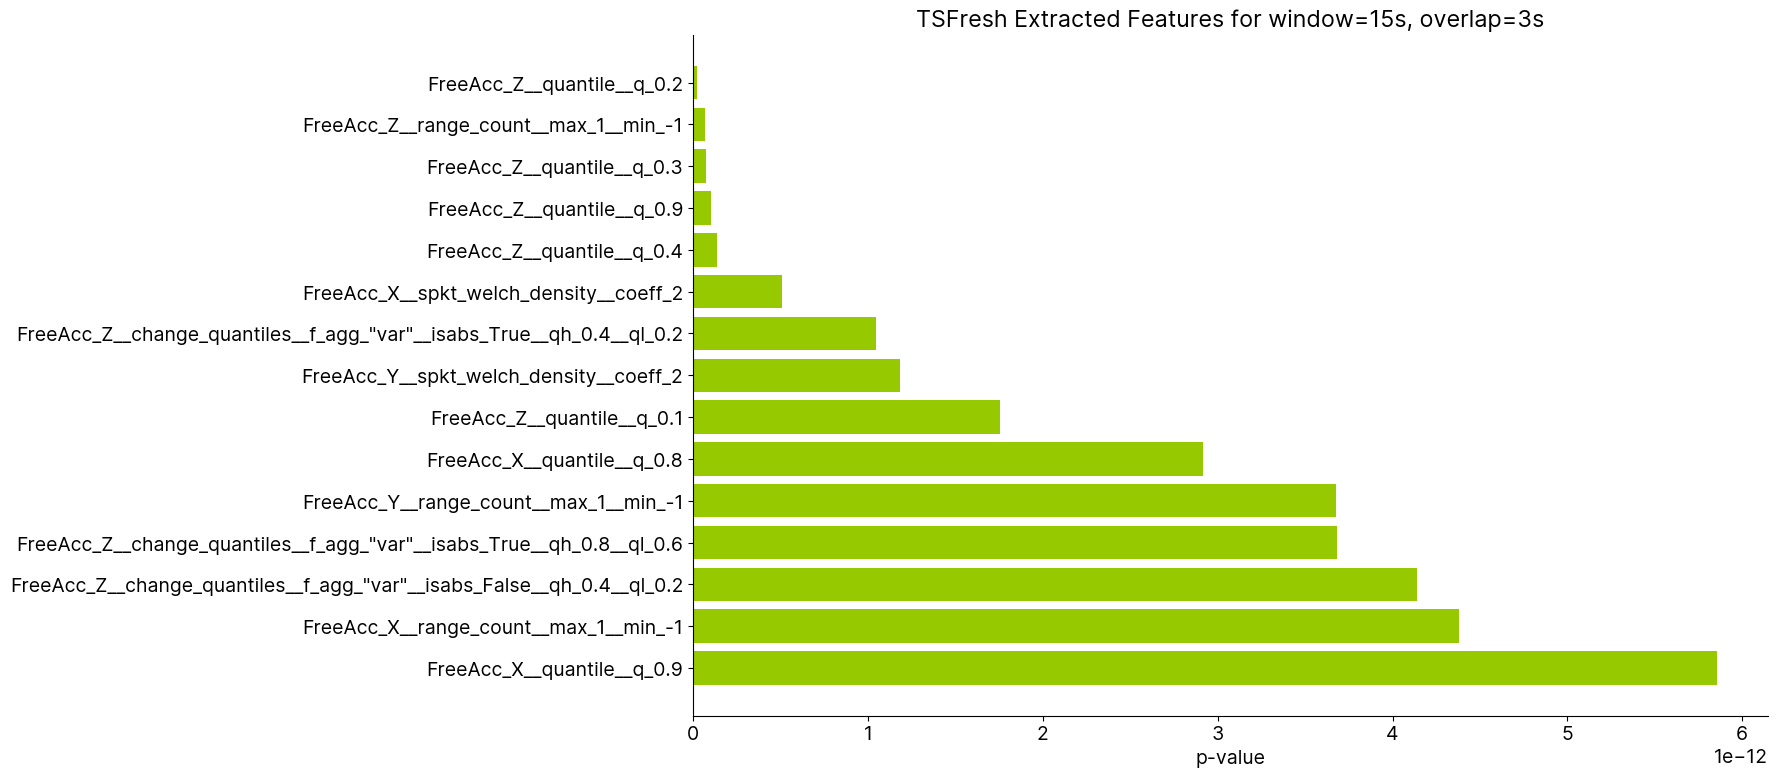

In [118]:
# plot as a bar chart
hard_col = "#97C900"

# font inter
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'Inter'})


fig = plt.figure(figsize=(18, 8))

plt.title("TSFresh Extracted Features for window=15s, overlap=3s")
plt.barh(relevance_table[:15]["feature"], relevance_table[:15]["p_value"], color=hard_col)

# add some spacing between 0 and the bars

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# label color: gray
# plt.tick_params(axis='x', colors='gray')
# plt.tick_params(axis='y', colors='gray')

plt.xlabel("p-value")
# plt.ylabel("Feature")

# flip the y-axis
plt.gca().invert_yaxis()

# prevent cutting off the labels
plt.tight_layout()

plt.savefig("exports/tsfresh_features_w15_o3.png", dpi=150)
plt.show()


In [90]:
# drop columns with NaN values
extracted_features_without_nan = impute(extracted_features)

# # now we can filter out the relevant features
filtered_features = select_features(extracted_features_without_nan, labels)
# filtered_features

In [29]:
filtered_features

,FreeAcc_X__spkt_welch_density__coeff_2,FreeAcc_Z__quantile__q_0.2,FreeAcc_Z__quantile__q_0.3,FreeAcc_Y__spkt_welch_density__coeff_2,FreeAcc_Z__quantile__q_0.4,FreeAcc_Z__range_count__max_1__min_-1,"FreeAcc_Y__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","FreeAcc_X__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""mean""",FreeAcc_Z__quantile__q_0.9,FreeAcc_Y__range_count__max_1__min_-1,...,"FreeAcc_Y__fft_coefficient__attr_""abs""__coeff_38","FreeAcc_X__fft_coefficient__attr_""abs""__coeff_31","Quat_Z__fft_coefficient__attr_""abs""__coeff_17","Quat_X__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""","FreeAcc_Z__fft_coefficient__attr_""abs""__coeff_48","FreeAcc_X__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""var""","Quat_Z__fft_coefficient__attr_""abs""__coeff_12","Quat_X__fft_coefficient__attr_""abs""__coeff_23",Quat_W__longest_strike_above_mean,Quat_Y__lempel_ziv_complexity__bins_3
0,56.018399,-1.270145,-0.846620,17.791079,-0.500896,470.0,0.003060,0.024231,2.289014,561.0,...,60.941798,69.016472,2.682401,3.0,84.664353,0.068955,9.401873,1.521274,87.0,0.093333
1,54.016443,-1.237079,-0.737861,19.836238,-0.377889,488.0,0.003039,0.024510,1.921962,595.0,...,110.819379,53.641234,4.132279,6.0,164.846753,0.037105,14.874541,2.493635,85.0,0.092222
2,39.308865,-1.213101,-0.821480,15.670417,-0.488492,484.0,0.002451,0.025129,2.053809,629.0,...,32.707724,59.093354,2.827831,4.0,122.216586,0.099944,6.890682,0.977734,165.0,0.094444
3,23.914923,-1.455044,-1.014195,20.995586,-0.631060,400.0,0.004813,0.018316,2.700637,494.0,...,135.540394,197.674203,6.512762,6.0,40.466103,0.105161,4.141085,1.887346,133.0,0.087778
4,41.904795,-2.004507,-1.219087,38.466143,-0.646011,338.0,0.005644,0.021997,3.195071,416.0,...,55.436115,145.818680,3.955637,6.0,244.695834,0.086945,1.878323,0.457429,100.0,0.090000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,4.001409,-0.557162,-0.297357,3.939709,-0.123420,714.0,0.003604,0.009409,1.006283,703.0,...,49.235616,59.540528,0.944385,16.0,102.863325,0.064035,1.240630,1.793139,250.0,0.084444
94,4.162882,-0.590683,-0.319851,4.169654,-0.123414,681.0,0.001789,0.011469,1.312712,760.0,...,55.981700,159.973962,0.964523,11.0,102.281600,0.044446,4.609248,1.441358,215.0,0.086667
95,6.246509,-0.692549,-0.416965,3.029159,-0.213969,663.0,0.001832,0.007486,1.214781,764.0,...,28.442242,72.176085,2.054764,13.0,52.320102,0.079026,3.132538,1.139581,198.0,0.086667
96,4.164478,-0.683025,-0.374405,1.668446,-0.157278,647.0,0.002050,0.010834,1.350889,715.0,...,25.097037,17.016426,2.156145,8.0,15.463303,0.067020,1.117347,1.460772,144.0,0.078889


In [88]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


class PCAForPandas(PCA):
    """This class is just a small wrapper around the PCA estimator of sklearn including normalization to make it 
    compatible with pandas DataFrames.
    """

    def __init__(self, **kwargs):
        self._z_scaler = StandardScaler()
        super(self.__class__, self).__init__(**kwargs)

        self._X_columns = None

    def fit(self, X, y=None):
        """Normalize X and call the fit method of the base class with numpy arrays instead of pandas data frames."""

        X = self._prepare(X)

        self._z_scaler.fit(X.values, y)
        z_data = self._z_scaler.transform(X.values, y)

        return super(self.__class__, self).fit(z_data, y)

    def fit_transform(self, X, y=None):
        """Call the fit and the transform method of this class."""

        X = self._prepare(X)

        self.fit(X, y)
        return self.transform(X, y)

    def transform(self, X, y=None):
        """Normalize X and call the transform method of the base class with numpy arrays instead of pandas data frames."""

        X = self._prepare(X)

        z_data = self._z_scaler.transform(X.values, y)

        transformed_ndarray = super(self.__class__, self).transform(z_data)

        pandas_df = pd.DataFrame(transformed_ndarray)
        pandas_df.columns = ["pca_{}".format(i) for i in range(len(pandas_df.columns))]

        return pandas_df

    def _prepare(self, X):
        """Check if the data is a pandas DataFrame and sorts the column names.

        :raise AttributeError: if pandas is not a DataFrame or the columns of the new X is not compatible with the 
                               columns from the previous X data
        """
        if not isinstance(X, pd.DataFrame):
            raise AttributeError("X is not a pandas DataFrame")

        X.sort_index(axis=1, inplace=True)

        if self._X_columns is not None:
            if self._X_columns != list(X.columns):
                raise AttributeError("The columns of the new X is not compatible with the columns from the previous X data")
        else:
            self._X_columns = list(X.columns)

        return X

In [91]:
# pca_train_3d = PCAForPandas(n_components=3)
# X_train_pca_3d = pca_train_3d.fit_transform(filtered_features)

pca_train_2d = PCAForPandas(n_components=2)
X_train_pca_2d = pca_train_2d.fit_transform(filtered_features)

In [92]:
X_train_pca_2d.to_csv("pca_2d.csv")

labels.to_csv("labels.csv")

# add a column with difficulty to the pca data 
# if False then "easy", if True then "hard"
X_train_pca_2d["difficulty"] = labels.map({False: "easy", True: "hard"})
X_train_pca_2d.to_csv("pca_2d.csv")



In [7]:
# X_train_pca_2d = pd.read_csv("pca_2d.csv", index_col=0)
# labels = pd.read_csv("labels.csv", index_col=0)

In [42]:
%matplotlib inline

In [4]:
from mpl_toolkits.mplot3d import Axes3D

NameError: name 'X_train_pca_3d' is not defined

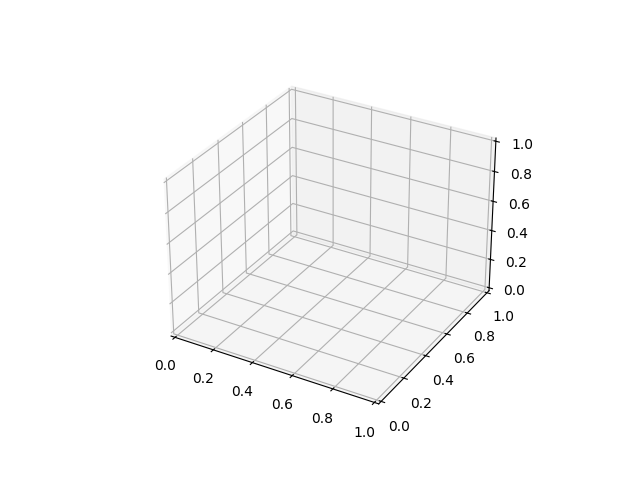

In [10]:
# plot X_train_pca  as 3d scatter plot


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train_pca_3d[labels == 0].iloc[:, 0], X_train_pca_3d[labels == 0].iloc[:, 1], X_train_pca_3d[labels == 0].iloc[:, 2], c='b', label="easy")
ax.scatter(X_train_pca_3d[labels == 1].iloc[:, 0], X_train_pca_3d[labels == 1].iloc[:, 1], X_train_pca_3d[labels == 1].iloc[:, 2], c='r', label="hard")

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.legend()

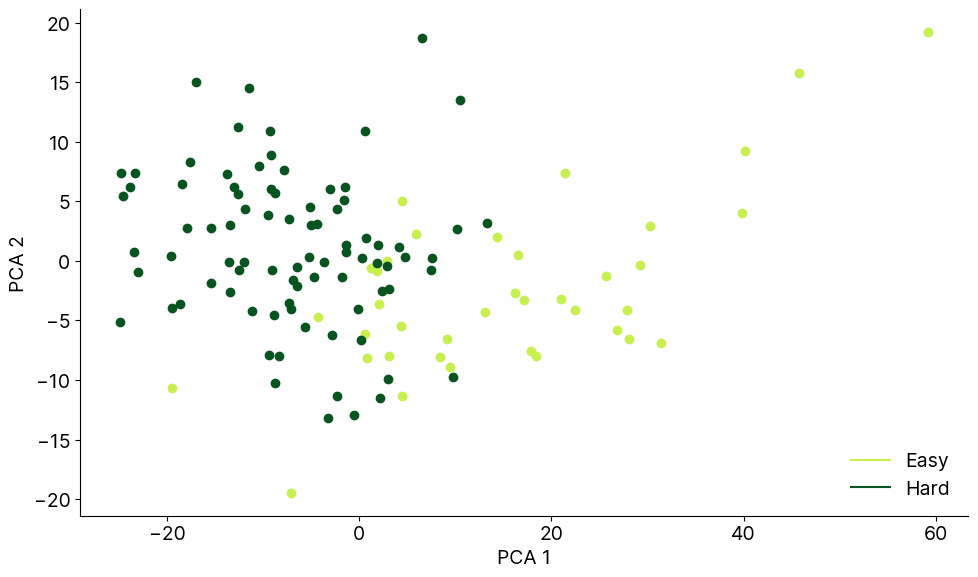

In [109]:
# plot X_train_pca  as 2d scatter plot
from matplotlib.lines import Line2D


fig = plt.figure(
    figsize=(10, 6)
)
ax = fig.add_subplot()

# set font to inter
plt.rcParams['font.family'] = 'Inter'

easy_col = "#C7EF4E"
hard_col = "#085420"

ax.scatter(X_train_pca_2d[labels == 0].iloc[:, 0], X_train_pca_2d[labels == 0].iloc[:, 1], c=easy_col, label="easy")
ax.scatter(X_train_pca_2d[labels == 1].iloc[:, 0], X_train_pca_2d[labels == 1].iloc[:, 1], c=hard_col, label="hard",)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')

# ax.legend()

#  add legend for colors
# from matplotlib.patches import Patch
legend_elements = [Line2D([0], [0], color=easy_col, label='Easy'),
                   Line2D([0], [0], color=hard_col, label='Hard')]
plt.legend(handles=legend_elements, frameon=False, loc="lower right")


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()


plt.savefig("exports/pca_2d.png", dpi=300)
plt.show()
